# Notebook 5: Inferring underlying parameters from data

In notebook 4 we investigated the connection between the underlying transmission process model and observable events. 
However, we used posterior mean estimates for the unknown parameters of the model. In this notebook, we look at how the posterior distributions for the parameters were generated. In this notebook we cover:

* Relative detection rate.
* The `CoVAreaModel` struct, this is the object that we use to contain available data for the county, and the log-likelihood model.
* Defining the parameters of the model using the `TransformVariables` package.
* Finding a good initialisation of the inference method.
* Running the inference method (Hamiltonian MCMC), and adding the results to the `CoVAreaModel` struct.

First, we load the data we need for the inference problem.

In [5]:
cd(joinpath(homedir(),"GitHub/KenyaSerology/")) #Sets the working directory to the /KenyaSerology directory
push!(LOAD_PATH, joinpath(homedir(),"GitHub/KenyaSerology/src")) #Adds the source code directory for KenyaSerology to the LOAD_PATH global variable

using JLD2,Plots,Dates
using Distributions,TransformVariables,LogDensityProblems #These packages define some useful methods

import KenyaSerology

#Load data
@load("data/projected_contact_data_10082020.jld2");
@load("data/case_data_by_area_21feb_to_6aug.jld2");
@load("data/serologydata_21feb_6aug.jld2");
@load("data/death_data_by_area_21feb_to_6aug.jld2"); 
@load("data/rel_sero_detection_after_infection.jld2");
@load("data/relative_testing_rate.jld2");

Each data file should be familiar from previous notebooks except `relative_testing_rate.jld2`. This file contains a linear fit to testing rate relative to the mean tests per day (2,482 tests per day which occured around 1st June). The extra testing rate seemed to apply mainly to Nairobi and surronding counties (Kiambu, Kajiado, Machakos). Therefore, in the underlying detection rate was assumed to be proportional to this increasing rate in those counties and flat in other counties. Samples from before 12th April are ignored in all counties (testing was extremely patchy before mid-April).

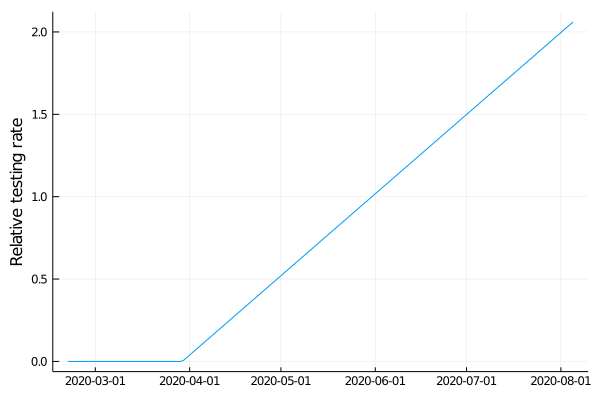

In [9]:
plot(relative_testing_rate_nairobi.date[relative_testing_rate_nairobi.date .< Date(2020,8,6)],
    relative_testing_rate_nairobi.relative_testing_rate[relative_testing_rate_nairobi.date .< Date(2020,8,6)],
    ylabel = "Relative testing rate",lab ="")

In [ ]:
transmission_prob = KenyaSerology.make_odeproblemforinference(projected_contactrate_nairobi,#Method for defining the ODE problem underlying the inference
                                                                                        startdate = Date(2020,2,21),#Don't change from Feb 21st as start date!
                                                                                        enddate = Date(2020,8,6)) #Solve until the end of the inference period


lwr_name = String([lowercase(s) for s in areaname])
        upr_name = String([uppercase(s) for s in areaname])
        cases = vec(case_data.cases[:,case_data.areas .== upr_name])
        sero = zeros(size(matchedserodata[:,1,:]))
        if sum(sero_data.areas.==lwr_name) > 0
           sero =  Matrix(matchedserodata[:,sero_data.areas.==lwr_name,:][:,1,:])
        end

        return KenyaSerology.CoVAreaModel(areaname = areaname,
                                        PCR_cases = cases,
                                        sero_cases = sero,
                                        dates = case_data.dates,
                                        N = popsize,
                                        γ = 1/(5.5 - 3.1),
                                        contactrate_data = projected_contactrate_kenya,
                                        prob = KenyaSerology.make_odeproblemforinference(projected_contactrate_mombasa,
                                                                                                startdate = Date(2020,2,21),
                                                                                                enddate = Date(2020,8,6)),
                                        sero_array = rel_sero_array_26days,
                                        log_priors = logprior,
                                        log_likelihood = KenyaSerology.loglikelihood_contactratemodelBB_Peff),vec(death_data.deaths[:,death_data.areas .== upr_name])